In [ ]:
!wget https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
!unzip individual+household+electric+power+consumption.zip

--2025-06-13 08:37:28--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘individual+household+electric+power+consumption.zip’

individual+househol     [    <=>             ]  19.68M  28.1MB/s    in 0.7s    

2025-06-13 08:37:29 (28.1 MB/s) - ‘individual+household+electric+power+consumption.zip’ saved [20640916]

Archive:  individual+household+electric+power+consumption.zip
  inflating: household_power_consumption.txt  


In [10]:
pip install Groq

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from groq import Groq
import json
import re
import os

In [23]:
Groq_api_key = 'api_key'
client =Groq(api_key=Groq_api_key)

In [24]:
#Load and and preprocess the dataset
def load_data_set():
    df = pd.read_csv('dataset/household_power_consumption.txt',
             	sep=';',
             	parse_dates={'datetime': ['Date', 'Time']},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')
    return df

In [25]:
# Function to generate pandas code from natural language question using GROQ API

def generate_pandas_code(natural_language_question, model_name, df_info):
    df_info_str = json.dumps(df_info)

    prompt = f"""
        You are a Python pandas and matplotlib expert. Given this preprocessed dataframe (index=datetime):

        PREPROCESSING CODE:
    
         df = pd.read_csv('dataset/household_power_consumption.txt',
             	sep=';',
             	parse_dates={{'datetime': {{'Date', 'Time'}}}},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

        df = df.dropna()
        df['Global_active_power'] = df['Global_active_power'].astype(float)
        df = df.set_index('datetime')
        
        Columns: {df_info_str}
        
        Generate ONLY executable Python/pandas code that:
        1. Answers the question: "{natural_language_question}"
        2. Stores final results in these standard variables when applicable:
           - avg_power_march, max_hour, weekday_avg, weekend_avg 
           - days_exceeded_5_kwh, daily_voltage, correlation
           - plot_data (for visualization outputs only)
        
        ONLY FOR VISUALIZATION QUERIES WHEN QUESTION CONTAINS KEY-WORDS like "plot", "visualize", "graph", "visualization":
            1. MUST include these elements in order:
               a) Data filtering/processing
               b) plt.figure() with size (10,6)
               c) ACTUAL PLOTTING COMMAND (plt.plot, plt.bar, etc.)
               d) Axis labels and title (plt.xlabel, plt.ylabel, plt.title)
               e) Save to "images/{model_name}/[sanitized_title].png"
               f) Buffer handling for plot_data
               g) plt.show()
               h) plt.close()
        
        EXAMPLE FOR QUESTION CONTAIN VISUALIZATION i.e "Plot the energy usage trend for the first week of January 2007."
        ```python
        # Filter data
        filtered = df[(df.index.year==2007) & (df.index.month==1)]
        daily = filtered['Global_active_power'].resample('D').mean()
        
        # Create plot
        plt.figure(figsize=(10,6))
        plt.plot(daily.index, daily, color='blue')  # <-- ACTUAL PLOT COMMAND
        plt.xlabel('Date')
        plt.ylabel('Power (kW)')
        title = 'January 2007 Daily Power Consumption'
        plt.title(title)
        
        # Save and store
        os.makedirs(f"images/{model_name}", exist_ok=True)
        filename = title.lower().replace(' ','_') + '.png'
        plt.savefig(f"images/{model_name}/filename.png")
        buf = io.BytesIO()
        buf.seek(0)
        plot_data = buf.getvalue()
        plt.show()
        plt.close()

        IMPORTANT RULES:
        (.)NEVER skip the actual plotting command (plt.plot, plt.bar, etc.) whereever needed if QUESTION CONTAIN KEY-WORDS.
        (.)show the plot (plt.show()) only for visual questions
        (.)Generate ONLY code - no explanations or markdown formatting
        (.)For non-visual questions, NEVER include plotting code AND ALWAYS PRINT THE FINAL RESULT.
    """
    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model=model_name,
            temperature=0.1,
        )
        return chat_completion.choices[0].message.content

    except Exception as e:
        print(f"GROQ API error: {e}")
        return None

In [26]:
# Function to execute the generated pandas code and display the output

def execute_query(query,model_name,df):
    df_info = {'columns': df.columns.tolist()}
    local_vars={}

    code = generate_pandas_code(query,model_name,df_info)
    #print("Python panda code is: \n",code)

    # Clean the code by removing markdown formatting so that it can be executed
    if code:
        code_clean = re.sub(r"```(?:python)?\n?|```", "", code).strip()
        code_clean = re.sub(r"<think>.*?</think>", "", code_clean, flags=re.DOTALL).strip()
        code_clean = code_clean.strip().split('\n')
        valid_lines = []
        for line in code_clean:
            # Include lines that look like real Python code (simple heuristic)
            if line.strip().startswith(("print", "df", "#", "import", "average", "result")) or "=" in line:
                valid_lines.append(line)

        final_code = '\n'.join(valid_lines)
        fixed_code = re.sub(
            r"df\[(df\.index\.\w+\s*==\s*\d+)\]\[(df\.index\.\w+\s*==\s*\d+)\]",
            r"df[(\1) & (\2)]",
            final_code
        )
        print("------------------------------------------------------------------------\nPython pandas Code is:\n\n", fixed_code)

    try:
        print("------------------------------------------------------------------------\nOutput of the code is:\n")
        exec_vars={'df':df,'plt':plt,'os':os}
        exec(fixed_code, exec_vars,local_vars) #execute the code in the context of the dataframe
         # Check if a plot was attempted but has 0 axes
        if 'plt' in exec_vars:
            fig = plt.gcf()
            if len(fig.axes) == 0 and any(line.strip().startswith(('plt.plot', 'plt.bar', 'plt.figure')) 
                                       for line in fixed_code.split('\n')):
                plt.close()
                print("Plot generation failed - empty figure detected")
                return False
        return True
    except Exception as e:
        print(f"Error executing code: {e}")
        return False

In [16]:
df = load_data_set()

In [17]:
print(df)

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

           

In [27]:
print(df.columns.tolist())
qwen_results={}

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


In [ ]:
#qwen/qwen3-32b model testing

# Consider for Analysis

In [28]:
value= execute_query("What was the average active power consumption in March 2007?", "qwen/qwen3-32b", df)
if(value):
    qwen_results["What was the average active power consumption in March 2007?"]=1
else:
    qwen_results["What was the average active power consumption in March 2007?"]=0
print(value)

GROQ API error: Connection error.
------------------------------------------------------------------------
Output of the code is:

Error executing code: local variable 'fixed_code' referenced before assignment
False


In [29]:
value= execute_query("What hour of the day had the highest power usage on Christmas 2006?","qwen/qwen3-32b",df)
if(value):
    qwen_results["What hour of the day had the highest power usage on Christmas 2006?"]=1
else:
    qwen_results["What hour of the day had the highest power usage on Christmas 2006?"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for Christmas 2006
filtered = df[(df.index.year == 2006) & (df.index.month == 12) & (df.index.day == 25)]
# Resample hourly and calculate mean active power
hourly_avg = filtered['Global_active_power'].resample('H').mean()
# Find the hour with the highest average power
max_hour = hourly_avg.idxmax().hour
print(max_hour)
------------------------------------------------------------------------
Output of the code is:

22
True


<Figure size 640x480 with 0 Axes>

In [31]:
value= execute_query("Compare energy usage (Global_active_power) on weekdays vs weekends","qwen/qwen3-32b",df)
if(value):
    qwen_results["Compare energy usage (Global_active_power) on weekdays vs weekends"]-1
else:
    qwen_results["Compare energy usage (Global_active_power) on weekdays vs weekends"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 # Classify weekdays vs weekends
df['DayType'] = df.index.dayofweek.apply(lambda x: 'Weekday' if x < 5 else 'Weekend')
# Calculate averages
weekday_avg = df[df['DayType'] == 'Weekday']['Global_active_power'].mean()
weekend_avg = df[df['DayType'] == 'Weekend']['Global_active_power'].mean()
# Print results
print(f"Weekday average power: {weekday_avg:.2f} kW")
print(f"Weekend average power: {weekend_avg:.2f} kW")
------------------------------------------------------------------------
Output of the code is:

Error executing code: 'Int64Index' object has no attribute 'apply'
False


In [32]:
value= execute_query("Find days where energy consumption exceeded 5 kWh.","qwen/qwen3-32b",df)
if(value):
    qwen_results["Find days where energy consumption exceeded 5 kWh"]=1
else:
    qwen_results["Find days where energy consumption exceeded 5 kWh"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 # Calculate daily energy consumption in kWh
daily_energy = df['Global_active_power'].resample('D').sum() * (1/60)
# Find days exceeding 5 kWh
days_exceeded_5_kwh = daily_energy[daily_energy > 5].index
# Print result
print(days_exceeded_5_kwh)
------------------------------------------------------------------------
Output of the code is:

DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='datetime', length=1409, freq=None)
True


<Figure size 640x480 with 0 Axes>

------------------------------------------------------------------------
Python pandas Code is:

 import matplotlib.pyplot as plt
import os
import io
# Filter data for first week of January 2007
filtered = df[(df.index.year == 2007) & (df.index.month == 1) & (df.index.day <= 7)]
daily = filtered['Global_active_power'].resample('D').mean()
# Create plot
plt.figure(figsize=(10,6))
plt.plot(daily.index, daily, color='blue')  # ACTUAL PLOT COMMAND
title = 'January 2007 First Week Daily Power Consumption'
# Save and store
os.makedirs(f"images/qwen/qwen3-32b", exist_ok=True)
filename = title.lower().replace(' ','_') + '.png'
buf = io.BytesIO()
plot_data = buf.getvalue()
------------------------------------------------------------------------
Output of the code is:

True


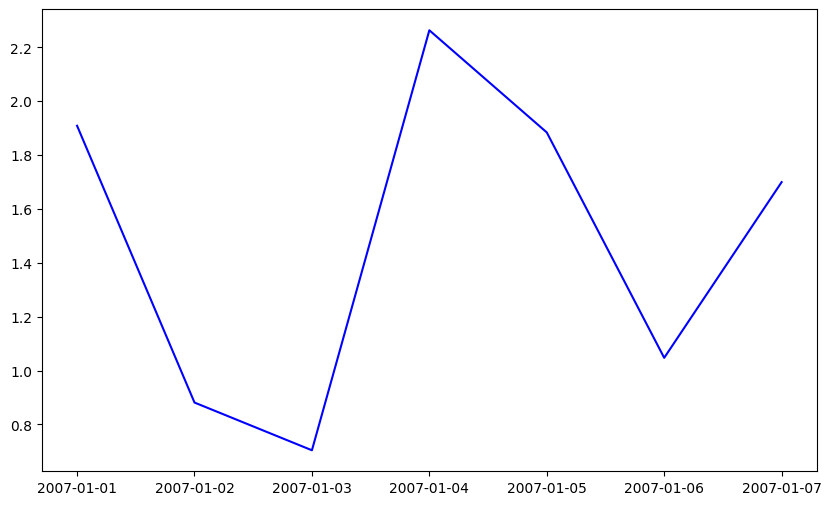

In [33]:
value= execute_query("Plot the energy usage trend for the first week of January 2007. Can you aggregrate data by month","qwen/qwen3-32b",df)
if(value):
    qwen_results["Plot the energy usage trend for the first week of January 2007. Can you aggregrate data by month"]=1
else:
    qwen_results["Plot the energy usage trend for the first week of January 2007. Can you aggregrate data by month"]=0
print(value)

In [35]:
value= execute_query("Find the average voltage for each day of the first week of February 2007","qwen/qwen3-32b",df)
if(value):
    qwen_results["Find the average voltage for each day of the first week of February 2007"]=1
else:
    qwen_results["Find the average voltage for each day of the first week of February 2007"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for first week of February 2007
filtered = df[(df.index.year == 2007) & (df.index.month == 2) & (df.index.day <= 7)]
# Calculate average voltage per day
daily_voltage = filtered['Voltage'].resample('D').mean()
print(daily_voltage)
------------------------------------------------------------------------
Output of the code is:

datetime
2007-02-01    240.392139
2007-02-02    240.334389
2007-02-03    238.910194
2007-02-04    239.633333
2007-02-05    240.810312
2007-02-06    241.264160
2007-02-07    241.149694
Freq: D, Name: Voltage, dtype: float64
True


<Figure size 640x480 with 0 Axes>

In [36]:
value = execute_query("What is the correlation between global active power and sub-metering values?","qwen/qwen3-32b",df)
if(value):
    qwen_results["What is the correlation between global active power and sub-metering values?"]=1
else:
    qwen_results["What is the correlation between global active power and sub-metering values?"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 correlation = df['Global_active_power'].corr(df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']])
print(correlation)
------------------------------------------------------------------------
Output of the code is:

Error executing code: operands could not be broadcast together with shapes (2049280,) (2049280,3) 
False


------------------------------------------------------------------------
Python pandas Code is:

 import matplotlib.pyplot as plt
import os
import io
# Calculate correlations
correlation = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr().loc['Global_active_power', ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
# Data processing for visualization
x = df['Global_active_power']
y1 = df['Sub_metering_1']
y2 = df['Sub_metering_2']
y3 = df['Sub_metering_3']
# Create plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].scatter(x, y1, alpha=0.5)
axs[1].scatter(x, y2, alpha=0.5)
axs[2].scatter(x, y3, alpha=0.5)
# Save and store
title = 'Correlation between Global Active Power and Sub-metering Values'
os.makedirs(f"images/qwen/qwen3-32b", exist_ok=True)
filename = title.lower().replace(' ','_') + '.png'
fig.savefig(f"images/qwen/qwen3-32b/{filename}", bbox_inches='tight')
buf = io.BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight')

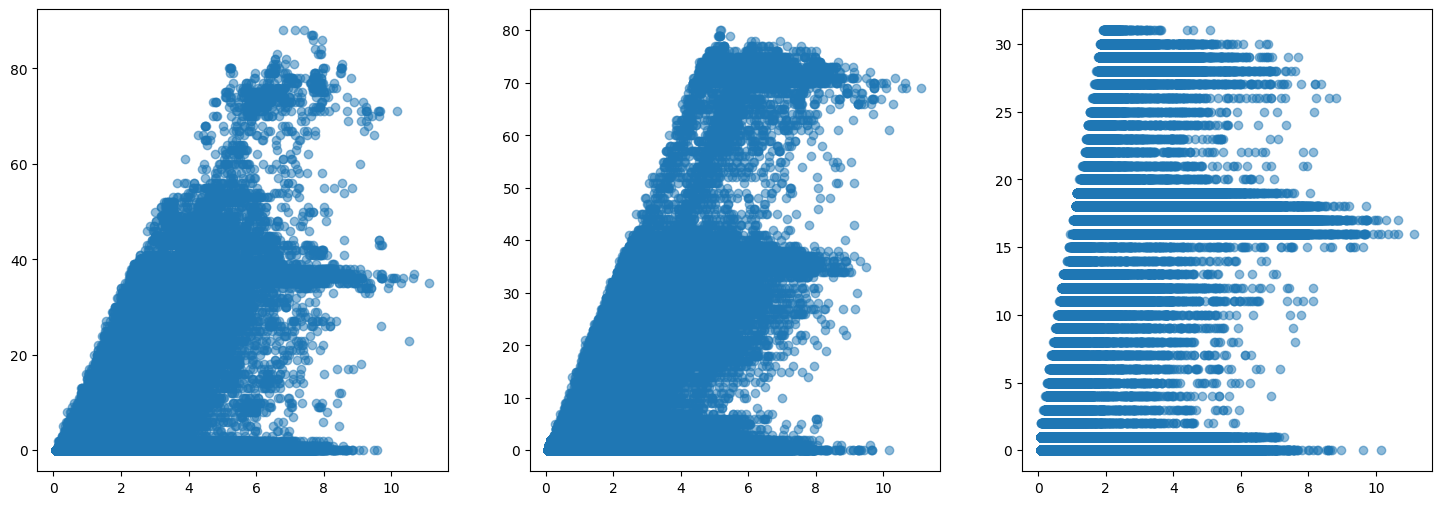

In [38]:
value = execute_query("What is the correlation between global active power and sub-metering values?. Can you show it using visualization","qwen/qwen3-32b",df)
if(value):
    qwen_results["What is the correlation between global active power and sub-metering values?. Can you show it using visualization"]=1
else:
    qwen_results["What is the correlation between global active power and sub-metering values?. Can you show it using visualization"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 import os
import io
import matplotlib.pyplot as plt
# Filter data
filtered = df[(df.index.year == 2007) & (df.index.month == 1) & (df.index.day <= 7)]
daily = filtered['Global_active_power'].resample('D').mean()
# Create plot
plt.figure(figsize=(10,6))
plt.plot(daily.index, daily, color='blue')
title = 'First Week of January 2007 Daily Power Consumption'
# Save to directory
os.makedirs("images/qwen/qwen3-32b", exist_ok=True)
filename = title.lower().replace(' ', '_') + '.png'
# Buffer handling
buf = io.BytesIO()
plot_data = buf.getvalue()
------------------------------------------------------------------------
Output of the code is:

True


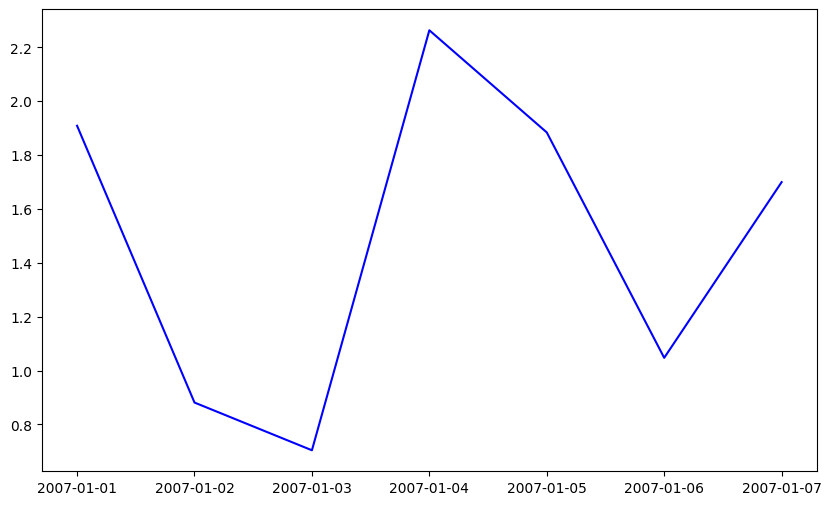

In [39]:
value = execute_query("Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day","qwen/qwen3-32b",df)
if(value):
    qwen_results["Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day"]=0
else:
    qwen_results["Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day"]=1
print(value)

In [40]:
execute_query("Find the average voltage for each day of the first week of February 2008","qwen/qwen3-32b",df)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for February 2008 first week
filtered = df[(df.index.year == 2008) & (df.index.month == 2) & (df.index.day <= 7)]
# Calculate daily average voltage
daily_voltage = filtered['Voltage'].resample('D').mean()
# Print result
print(daily_voltage)
------------------------------------------------------------------------
Output of the code is:

datetime
2008-02-01    240.360271
2008-02-02    240.290514
2008-02-03    240.340722
2008-02-04    240.255208
2008-02-05    240.976917
2008-02-06    238.413715
2008-02-07    241.070549
Freq: D, Name: Voltage, dtype: float64


True

<Figure size 640x480 with 0 Axes>

In [41]:
execute_query("Find days where total energy consumption exceeded 2 kWh in 2008","qwen/qwen3-32b",df)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for 2008
filtered = df[df.index.year == 2008]
# Calculate daily energy consumption (kWh)
daily_energy = filtered['Global_active_power'].resample('D').sum() * (1/60)
# Find days exceeding 2 kWh
days_exceeded_5_kwh = daily_energy[daily_energy > 2].index
------------------------------------------------------------------------
Output of the code is:



True

<Figure size 640x480 with 0 Axes>

In [5]:
qwen_results={}

In [8]:
for k,v in qwen_results.items():
    print(k,": ",v)

What was the average active power consumption in March 2007? :  0
What hour of the day had the highest power usage on Christmas 2006? :  1
Compare energy usage (Global_active_power) on weekdays vs weekends :  0
Find days where total energy consumption exceeded 5 kWh :  1
Plot the energy usage trend for the first week of January 2007. Can you aggregrate data by month :  1
Find the average voltage for each day of the first week of February 2007 :  1
What is the correlation between global active power and sub-metering values? :  0
What is the correlation between global active power and sub-metering values?. Can you show it using visualization :  1
Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day :  1


In [7]:
%store qwen_results

Stored 'qwen_results' (dict)
